## FLAME Workflow - Mullion - 26NOV20 PM - Droniometer First Test

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np 
import glob, os, subprocess, time
from dateutil import parser
from scipy import interpolate


import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, shutil
sys.path.append("..")

from SRC import *

%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams['savefig.dpi'] = 300


indir = '../MULLION/26NOV20/RAW_DATA/Flame_26_11/Flame_2020_11_26_pm/'
outdir = '../PNGS/MULLION/26NOV20/'
calfile = '../CALIBRATION/RadCalCoeff_GT08_.csv'
calfile2 = '../CALIBRATION/RoughFlameCal.csv'
#TelemetryFile = '../MULLION/26NOV20/RAW_DATA/log_files/Nov-26th-2020-11-21AM-Flight-Airdata.csv'
TelemetryFile = '../MULLION/26NOV20/RAW_DATA/log_files/Nov-26th-2020-12-21PM-Flight-Airdata.csv'


field_data = ['MUL', '26NOV20', 'Flame_Droniometer_PM', 'Landsat8', 'GA 10inch Panel 99aa03-0319-1952', 'Radiance', '', 'C5']

fignum=1


#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 1

plot_scale = [0.0, 1.0, 0.0, 1.0]
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'
panel_dir =  '../../../CalVal_Phase1/RAW_DATA/Panels/'
in_panel = 'GA_10inch.txt'

sat_resp = dict({'Landsat5': '../../../CalVal_Phase1/SENSOR_BANDS/landsat5_vsir.flt', 
            'Landsat7': '../../../CalVal_Phase1/SENSOR_BANDS/landsat7_vsir.flt', 
            'Landsat8': '../../../CalVal_Phase1/SENSOR_BANDS/landsat8_vsir.flt',
            'Sentinel2a': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2a.flt',
            'Sentinel2b': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

In [2]:
TeleDat = pd.read_csv(TelemetryFile)
#TeleDat1 = pd.read_csv(TelemetryFile1)
#TeleDat2 = pd.read_csv(TelemetryFile2)
#TeleDat = pd.concat([TeleDat1, TeleDat2])

In [3]:
TeleDat.drop(['height_above_ground_at_drone_location(meters)', 
              'ground_elevation_at_drone_location(meters)',
              'satellites',
              'gpslevel',
              'voltage(v)',
              'max_altitude(meters)',
              'max_ascent(meters)',
              'max_speed(m/s)',
              'max_distance(meters)',
              ' xSpeed(m/s)',
              ' ySpeed(m/s)',
              ' zSpeed(m/s)',
              'isPhoto',
              'isVideo',
              'rc_elevator',
              'rc_aileron',
              'rc_throttle',
              'rc_rudder',
              'battery_percent',
              'voltageCell1',
              'voltageCell2',
              'voltageCell3',
              'voltageCell4',
              'voltageCell5',
              'voltageCell6',
              'current(A)',
              'battery_temperature(c)',
              'altitude(meters)',
              'ascent(meters)',
              'flycStateRaw',
              'flycState'], axis=1, inplace=True)

In [4]:
TeleDat.rename(columns={'time(millisecond)': 'time_ms',
                        'datetime(utc)': 'datetime',
                        'latitude': 'Latitude',
                        'longitude': 'Longitude',
                        'height_above_takeoff(meters)': 'height_local',
                        'altitude_above_seaLevel(meters)': 'height_sea',
                        'distance(meters)': 'distance(m)',
                        ' compass_heading(degrees)': 'compass_heading',
                        ' pitch(degrees)': 'pitch',
                        ' roll(degrees)': 'roll',
                        'gimbal_heading(degrees)': 'gimbal_heading',
                        'gimbal_pitch(degrees)': 'gimbal_pitch',
                        'message': 'comment'
                       }, inplace=True
              )

In [5]:
TeleDat['datetime'] = [parser.parse(TeleDat.datetime[i]) for i in range(len(TeleDat.datetime))]

In [6]:
TeleDat = TeleDat[TeleDat['datetime'] > datetime(2020,4,14,1,53,0)]

In [7]:
TeleDat['date_saved'] = [TeleDat.datetime.iloc[1] + timedelta(milliseconds=int(TeleDat.time_ms.iloc[i])) + timedelta(milliseconds=200) for i in range(len(TeleDat.datetime))]

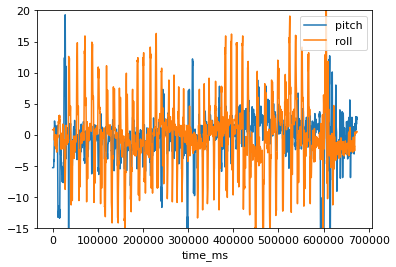

In [8]:
TeleDat.plot('time_ms', ['pitch', 'roll'], ylim=(-15,20))

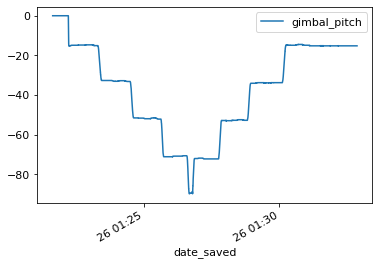

In [9]:
TeleDat.plot('date_saved', 'gimbal_pitch')
#plt.savefig('gimbal_pitch.png')

In [10]:
alldata = LoadData.load_from_dir(indir, calfile)

### Rough Calibration fix

In [11]:
cf2 = pd.read_csv(calfile2)
cf2.rename(columns={'wl': 'Wavelength'}, inplace=True)
cf2.set_index('Wavelength', inplace=True)

rcm = []
for i in alldata.SpecNum.unique():
    rcm.append(cf2['rad_cal_mean'].values)
    
flat_list = [item for sublist in rcm for item in sublist]

alldata['cal2'] = flat_list

In [12]:
#
# Slightly adjust wavelength in calibration file to take into new Flame calibration, post OCT 2020
#
def rejig_cal_wavelength(calfile, alldata):
    caldata = pd.read_csv(calfile)
    func = interpolate.interp1d(caldata.wl, caldata.rad_cal_mean)
    alldata['CalData'] = func(alldata.index)
    
    return alldata

alldata = rejig_cal_wavelength(calfile, alldata)

In [13]:
#
# Define radiance based on DN data, calibration data and integration time
# Also set Line number = 1 to allow easy processing
#
# alldata['radiance'] = alldata.DN*alldata.CalData/alldata.IntTime  # Original: works with good calibration
alldata['radiance'] = alldata.DN*alldata.cal2*0.00224/alldata.IntTime # Rough Calibration fix
alldata['Line']=1

In [14]:
#
# Bin spectra into integer wavelength bins, assuming that the input data
# has 0.3nm channels.
#
def wavelength_bin(alldata):
    # Create avgdata DataFrame, based on alldata input DataFrame
    # Reset index so that Wavelength is not the index.
    avgdata = alldata.copy()
    avgdata.reset_index(inplace=True)
    
    ### Make a mean of three rows for each of DN, Calibration, Radiance
    ###avgdata['DNmean'] = avgdata.DN.rolling(3, center=True).mean()
    ###avgdata['Calmean'] = avgdata.CalData.rolling(3, center=True).mean()
    ###avgdata['Radmean'] = avgdata.radiance.rolling(3, center=True).mean()
    
    # Remove first and last wavelengths which have NaNs in them.
    avgdata = avgdata[avgdata.Wavelength != 349.176]
    avgdata = avgdata[avgdata.Wavelength != 910.925]
    
    # Create empty output DataFrame
    outputDF = pd.DataFrame()
    ttmm = pd.DataFrame()
    
    # Loop through each spectrum in the dataframe
    for j in avgdata.SpecNum.unique():
        tempdata = avgdata[avgdata.SpecNum==j].groupby(pd.cut(avgdata[avgdata.SpecNum==j]['Wavelength'], np.arange(349.5,910.5,1.0))).mean()
        tempdata['date_saved'] = avgdata[avgdata.SpecNum==j].date_saved.values[0]
        tempdata['filename'] = avgdata[avgdata.SpecNum==j].filename.values[0]
        
        tempdata.index.rename('plop', inplace=True)
        tempdata.reset_index(inplace=True)
        tempdata.drop(columns='plop', inplace=True)
        tempdata.Wavelength = tempdata.Wavelength.round(0).astype(int)        
        
        # When finished making an entire spectrum, add it to the output DataFrame
        # and print how many have been done.
        if outputDF.empty:
            outputDF = tempdata.copy()
        
        else:
            if j % 100 == 0:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
                ttmm = pd.DataFrame()
            
            elif j == len(avgdata.SpecNum.unique())-1:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
            
            elif ttmm.empty:
                ttmm = tempdata.copy()
            
            else:
                ttmm = pd.concat([ttmm, tempdata])
                
            
        print('Completed ', j+1, '/', len(avgdata.SpecNum.unique()), ' spectra', end='\r', flush=True)

    # output final DataFrame
    return outputDF

avgdata = wavelength_bin(alldata)

In [15]:
#alldat = avgdata.reset_index()

In [16]:
#avgdata[avgdata.Wavelength==550]

In [17]:
merge_data = pd.merge_asof(avgdata, TeleDat, on='date_saved')

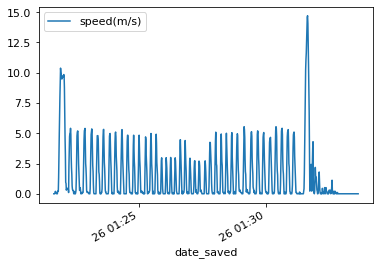

In [18]:
merge_data[merge_data.Wavelength==550].plot('date_saved', 'speed(m/s)')
#plt.savefig('pics/gimbal_pitch.png')

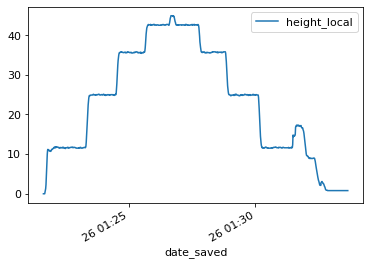

In [19]:
merge_data.plot('date_saved', 'height_local')

In [20]:
def scatter_plot(xdata, ydata):
    plt.scatter(xdata, ydata, s=3)
    plt.xlim(xdata.min(), xdata.max())
    plt.ylim(ydata.min(), ydata.max())

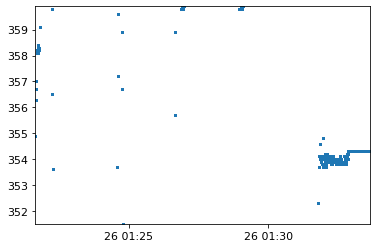

In [21]:
scatter_plot(merge_data[merge_data.compass_heading > 350]['date_saved'], merge_data[merge_data.compass_heading > 350]['compass_heading'])

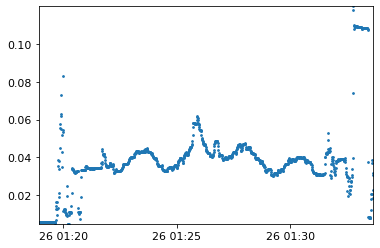

In [22]:
scatter_plot(merge_data[merge_data.Wavelength==550]['date_saved'], merge_data[merge_data.Wavelength==550]['radiance'])

In [23]:
#
# Define panels in terms of 550nm radiance is greater than 0.1. THis step is only a temporary fix
# since this dataset does not have panel data in i (has to come from SR3500, which was recording
# downwelling.
#
tmp_panels = merge_data[np.logical_and(merge_data.Wavelength==550, merge_data.radiance > 0.1)]

In [24]:
#all_panels = merge_data.loc[merge_data['date_saved'].isin(tmp_panels.date_saved)]

In [25]:
#scatter_plot(all_panels[all_panels.Wavelength==550].date_saved, all_panels[all_panels.Wavelength==550].radiance)

In [26]:
#
# Select only spectra relevant to droniometer measurement.
#

# Make sure all latitudes are in the Southern Hemisphere.
merge_data = merge_data[merge_data.Latitude < 0]

# Only select spectra where the drone is close to stopped.
# NOTE: one spectrum is missed for speeds lower than 0.5m/s in the AM dataset for 26NOV20.
merge_data = merge_data[merge_data['speed(m/s)']<0.5]

# Select strict time range for spectra to be included.
merge_data = merge_data[merge_data.date_saved > datetime(2020,11,26,1,20,0)]
merge_data = merge_data[merge_data.date_saved < datetime(2020,11,26,1,31,30)]

#Ensure gimbal was always pointing down.
merge_data = merge_data[merge_data.gimbal_pitch < 0]

In [27]:
all_grounds = merge_data[np.logical_and(merge_data.date_saved > datetime(2020,11,10,2,19,15), merge_data.date_saved < datetime(2020,12,10,2,24,20))]

In [28]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)

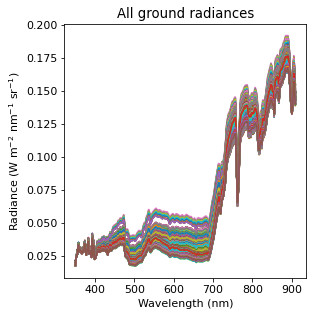

In [29]:
FIG_GroundSpectra.FIG_ground_spectra(all_grounds_spec, outdir, field_data, fignum)
fignum +=1

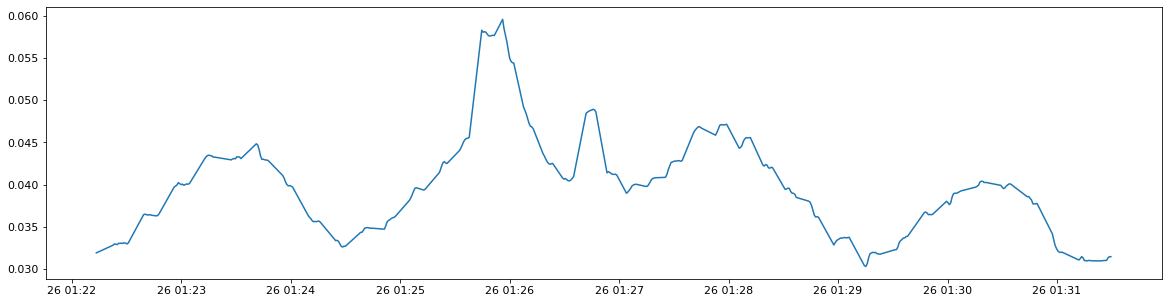

In [30]:
plt.subplots(nrows=1, ncols=1, figsize=(20,5))
plt.plot(merge_data[merge_data.Wavelength==550]['date_saved'], merge_data[merge_data.Wavelength==550]['radiance'])
#plt.xlim(pd.datetime(2020,11,26,0,30), pd.datetime(2020,11,26,0,35))

In [31]:
def add_polar_points(merge_data):
    #
    # Mirror compass headings close to 0 degrees / 360 degrees around the 0 degree azimuth axis.
    # This helps reduce gaps of data close to the 0 degree azimuth axis.
    #
    tmpdf1 = merge_data[merge_data.compass_heading < 2].copy()
    tmpdf1.compass_heading = 360.0
    tmpdf2 = merge_data[merge_data.compass_heading < 2].copy()
    tmpdf2.compass_heading = 0.0
    tmpdf3 = merge_data[merge_data.compass_heading > 358].copy()
    tmpdf3.compass_heading = 0.0
    tmpdf4 = merge_data[merge_data.compass_heading > 358].copy()
    tmpdf4.compass_heading = 360.0
    merge_data = pd.concat([merge_data, tmpdf1, tmpdf2, tmpdf3, tmpdf4])

    #
    # For all of the spectra with gimbal pitch less than -85.5 degees (ie. pointing straight down),
    # fudge the compass heading so that the spectra are equally spaced out in azimuth. This reduces
    # null areas, plus keeps the appearance symmetrical close to the apex of the polar plot.
    #
    for idx, item in enumerate(merge_data[merge_data.gimbal_pitch<-85.5].SpecNum.unique()):
        merge_data.loc[merge_data.SpecNum==item, 'compass_heading'] = idx*360/len(merge_data[merge_data.gimbal_pitch<-85.5].SpecNum.unique())

    return merge_data

merge_data = add_polar_points(merge_data)

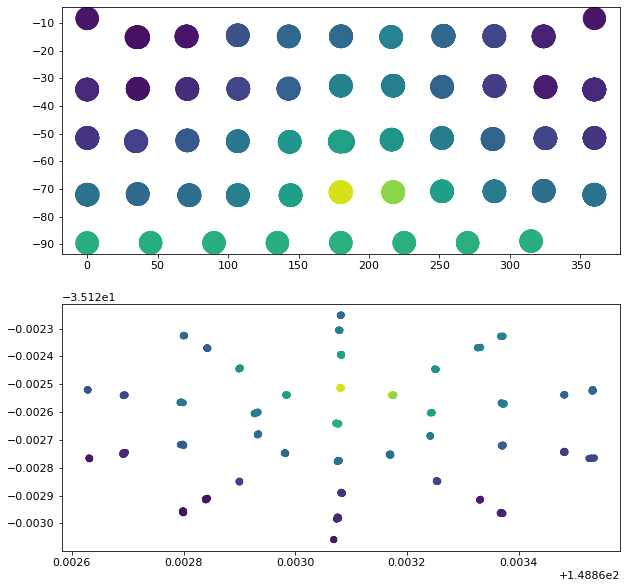

In [32]:
#
# Plot in linear coordinates the compass heading of drone (x-axis) vs. gimbal pitch (y-axis) for upper plot.
# Lower plot shows longitude/latitude of spectra
#
fig = plt.figure(figsize=(10,10))
#plt.tight_layout(pad=2, w_pad=5, h_pad=10)
ax1 = fig.add_subplot(211)#, projection='polar')
ax2 = fig.add_subplot(212)
ax1.scatter(merge_data[merge_data.Wavelength==550].compass_heading, merge_data[merge_data.Wavelength==550].gimbal_pitch, c=merge_data[merge_data.Wavelength==550].radiance, s=500)#, cmap='hsv', alpha=0.75)
ax2.scatter(merge_data[merge_data.Wavelength==550].Longitude, merge_data[merge_data.Wavelength==550].Latitude, c=merge_data[merge_data.Wavelength==550].radiance)
plt.savefig('polartest.png')

(-35.1232, -35.1221)

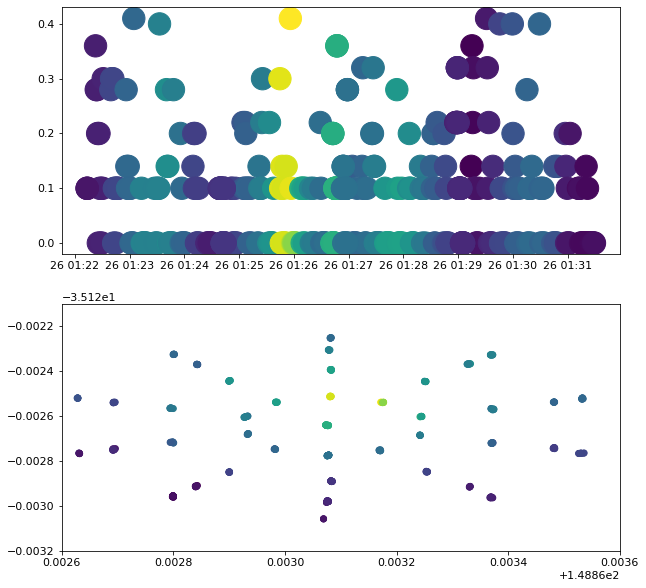

In [33]:
#
# Plot time vs. drone speed and lat/lon coordinates, for testing purposes
#

fig = plt.figure(figsize=(10,10))
#plt.tight_layout(pad=2, w_pad=5, h_pad=10)
ax1 = fig.add_subplot(211)#, projection='polar')
ax2 = fig.add_subplot(212)
ax1.scatter(merge_data[merge_data.Wavelength==550].date_saved, merge_data[merge_data.Wavelength==550]['speed(m/s)'], c=merge_data[merge_data.Wavelength==550].radiance, s=500)#, cmap='hsv', alpha=0.75)
ax2.scatter(merge_data[merge_data.Wavelength==550].Longitude, merge_data[merge_data.Wavelength==550].Latitude, c=merge_data[merge_data.Wavelength==550].radiance)
ax2.set_xlim(148.8626, 148.8636)
ax2.set_ylim(-35.1232, -35.1221)

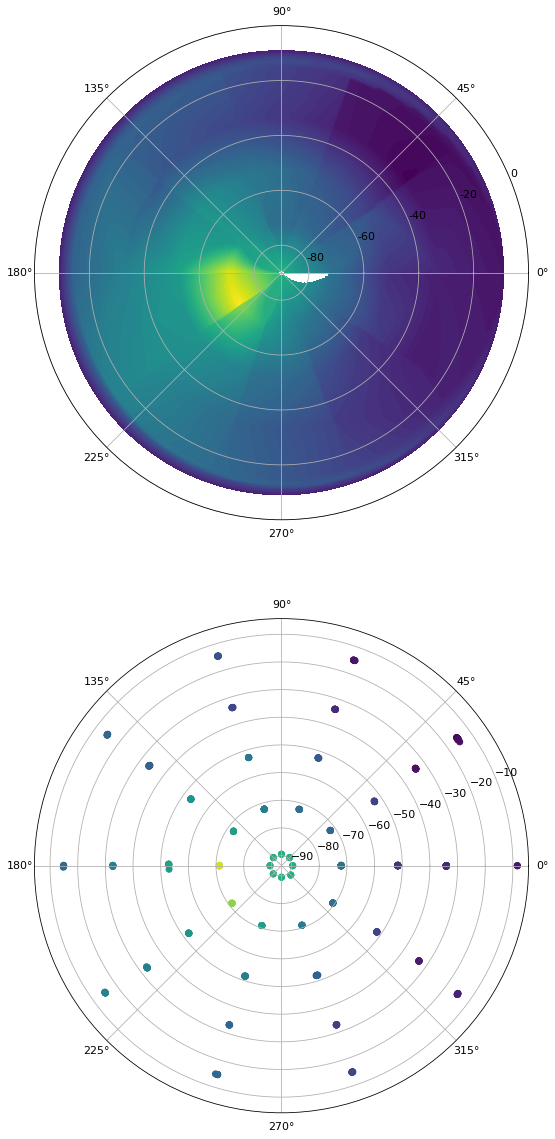

In [34]:
def polar_plot(azimuth, radial, value, outdir, field_data, fignum):

    #
    # Make polar axis plots. 
    # Upper shows filled in plane with azimuth = compass heading, radial = gimbal pitch
    # Lower shows just the data points themselves.
    #

    # Size of regular grid
    ny, nx = 90, 360

    # Generate a regular grid to interpolate the data.
    # Note polar plots have to be in units of radians, so azimuth goes from 0 to 2xPi and radial gos from -Pi/2 to 0
    xi = np.linspace(0, 2.0*np.pi, nx)
    yi = np.linspace(-0.5*np.pi, 0, ny)
    Xi, Yi = np.meshgrid(xi, yi)

    # Define "points" variable to be compass heading and gimbal pitch in radians
    points = (np.deg2rad(azimuth), np.deg2rad(radial))

    # Define value for each point to be the radiance value at 550nm
    values = value

    #Interpolate the data onto a grid that has points spaced by 1 degree. Add fill_value if you want zeroes plotted.
    regridded = interpolate.griddata(points, values, (Xi, Yi), method='linear')  #, fill_value=0)

    fig = plt.figure(figsize=(10,20))
    ax1 = fig.add_subplot(211, projection='polar')
    ax2 = fig.add_subplot(212, projection='polar')

    ax1.contourf(xi, yi, regridded, 90)
    ax2.scatter(np.deg2rad(azimuth), radial, c=value)

    # Have to fudge the radial axis to display in units of degrees (azimuth axis does this automatically)
    # So create ticketyboo variable manually and use that to plot both ticks and labels.
    ax1.set_ylim(-0.5*np.pi, 0)
    ticketyboo = np.linspace(-80, 0, 5).astype(int)
    ax1.set_yticks(np.deg2rad(ticketyboo))
    ax1.set_yticklabels(ticketyboo)

    plt.savefig(outdir+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_'+'Fig'+str(fignum)+'PolarPlot.png', dpi=300)
    
polar_plot(merge_data[merge_data.Wavelength==550].compass_heading, merge_data[merge_data.Wavelength==550].gimbal_pitch, merge_data[merge_data.Wavelength==550].radiance, outdir, field_data, fignum)

In [35]:
allSR3500data = LoadSR3500Data.load_from_dir('/g/data/up71/projects/CalVal_Phase2/SR3500/26NOV20/RAW_DATA/SR3500/26_11_BRDF/3500_26_11/2020_Nov_26_pm/')

In [36]:
allSR3500data['radiance'] =allSR3500data['Rad_Target']#/np.pi
allSR3500data['Line'] = 1

In [37]:
allSR3500data.rename(columns={'Spec_number': 'SpecNum'}, inplace=True)

In [38]:
all_panels = allSR3500data.copy()
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)

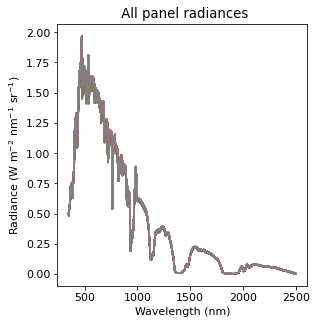

In [39]:
FIG_PanelRadiances.FIG_panel_radiances(all_panel_spec, outdir, field_data, fignum)

fignum += 1

In [40]:
#all_panels.Longitude = all_panels.Longitude.fillna(148.862692)
#all_panels.Latitude = all_panels.Latitude.fillna(-35.123277)

#all_grounds.Longitude = all_grounds.Longitude.fillna(148.862692)
#all_grounds.Latitude = all_grounds.Latitude.fillna(-35.123277)

In [41]:
all_panels, all_grounds = SolarAngle.solar_angle(all_panels, all_grounds, field_data)

In [42]:
good_panels = all_panels.copy()
good_grounds = all_grounds.copy()

In [43]:
#all_panels = PanelBRF.Panel_BRF(all_panels, field_data)

In [44]:
gpta, adta = CreateTimeRelativeDF.create_time_relative_dfs(all_panels, all_grounds)

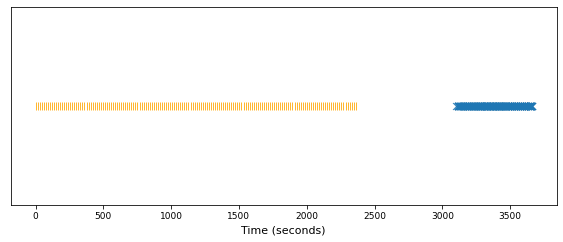

In [45]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, outdir, field_data, fignum)
fignum += 1

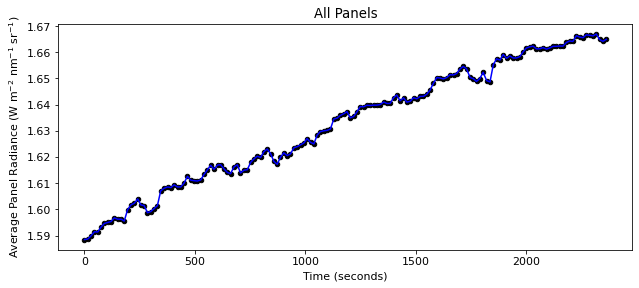

In [46]:
all_panel_mean = all_panel_spec.mean(axis=1)

gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(all_panel_mean, all_panel_spec, gpta, field_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpta, outdir, field_data, fignum)

fignum += 1

In [47]:
gpta['Latitude'] = -35.123277
gpta['Longitude'] = 148.862692
adta['Latitude'] = -35.123277
adta['Longitude'] = 148.862692

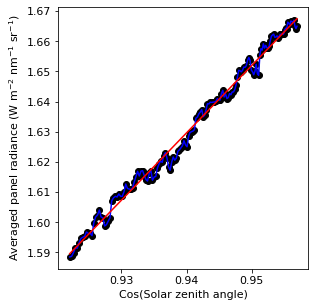

In [48]:
slope, intercept, coszenith = FIG_InsolationFit.FIG_insolation_fit(gpta, outdir, field_data, fignum)
fignum += 1

### Scale good panels to insolation curve

Use the fitted insolation curve to determine individual offsets for each panel measurement and then divide<BR>
off the differences. This effectively removes any individual variations in the absolute scaling of panel<BR>
measurements.

In [49]:
good_panels = ScalePanels.scale_panels(slope, intercept, coszenith, gpta, good_panels, field_data)

### Scale ground spectra to insolation curve

For each line, calculate the mean panel spectrum and determine the fit at the according mean Solar zenith angle.<BR>
Then determine individual fits for all ground data within the line and apply the ratio of the panel mean fit to<BR>
ground fit to the good_grounds dataframe.

In [50]:
good_grounds = ScaleGrounds.scale_grounds(good_panels, good_grounds, slope, intercept, field_data)

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [51]:
k_f = KFactor.k_factor(panel_dir, in_panel)

In [52]:
k_f = k_f[k_f.index <910]

In [53]:
good_panels = good_panels[good_panels.Wavelength < 910]

### Re-Make Spectral Dataframes

After re-scaling of both good_panels and good_grounds, recreate the good_panel_spec and<BR>
good_grounds_spec dataframes

In [54]:
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [55]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, field_data)

In [56]:
good_panel_spec = good_panel_spec.rename(columns={x:y for x,y in zip(good_panel_spec.columns,range(len(good_panel_spec.columns)))}).add_prefix('radiance1-')
good_grounds_spec = good_grounds_spec.rename(columns={x:y for x,y in zip(good_grounds_spec.columns,range(len(good_grounds_spec.columns)))}).add_prefix('radiance1-')


### Create dataframe with Reflectances

In [57]:
all_refls = CreateReflectancesWithCosineDiffuser.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, field_data)

../SRC/CreateReflectancesWithCosineDiffuser.py:52: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  line_refls = pd.np.multiply(refl_tmp, Factor)


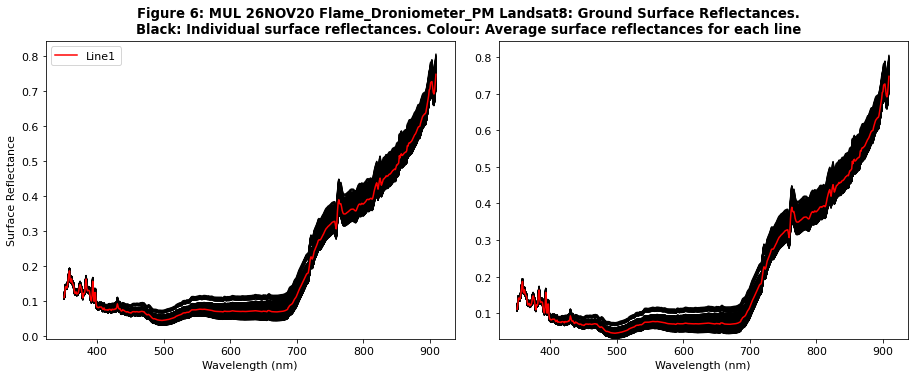

In [58]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, outdir, field_data, fignum)
fignum += 1

In [59]:
flameavg = all_refls.mean(axis=1)

In [60]:
asdavg = pd.read_pickle('PICKS/26NOV20_asd.pick')

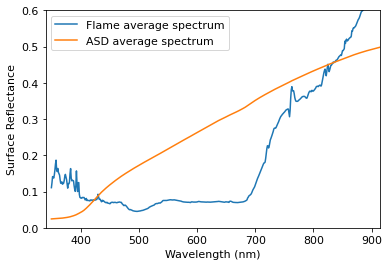

In [61]:
plt.plot(flameavg)
plt.plot(asdavg)
plt.ylim(0,0.6)
plt.xlim(340,915)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface Reflectance')
plt.legend(['Flame average spectrum', 'ASD average spectrum'])
plt.savefig('comp.png')

In [62]:
all_panels[all_panels.Wavelength==350]

,Wavelength,Rad_Target,filename,date_saved,IntTime,Latitude,Longitude,SpecNum,radiance,Line,Solar_angle
0,350.0,0.48158,SR-3500_SN20680T1_00000.sed,2020-11-26 00:30:29,30.0,-35.124189,148.862583,0,0.48158,1,22.766265
0,350.0,0.48162,SR-3500_SN20680T1_00001.sed,2020-11-26 00:30:44,30.0,-35.124202,148.862579,1,0.48162,1,22.723418
0,350.0,0.48207,SR-3500_SN20680T1_00002.sed,2020-11-26 00:30:59,30.0,-35.124189,148.862570,2,0.48207,1,22.680610
0,350.0,0.48275,SR-3500_SN20680T1_00003.sed,2020-11-26 00:31:14,30.0,-35.124181,148.862606,3,0.48275,1,22.637824
0,350.0,0.48289,SR-3500_SN20680T1_00004.sed,2020-11-26 00:31:29,30.0,-35.124210,148.862613,4,0.48289,1,22.595128
...,...,...,...,...,...,...,...,...,...,...,...
0,350.0,0.51020,SR-3500_SN20680T1_00153.sed,2020-11-26 01:08:50,30.0,-35.124213,148.862579,153,0.51020,1,16.998332
0,350.0,0.51011,SR-3500_SN20680T1_00154.sed,2020-11-26 01:09:05,30.0,-35.124206,148.862589,154,0.51011,1,16.967903
0,350.0,0.50943,SR-3500_SN20680T1_00155.sed,2020-11-26 01:09:20,30.0,-35.124206,148.862596,155,0.50943,1,16.937603
0,350.0,0.50899,SR-3500_SN20680T1_00156.sed,2020-11-26 01:09:35,30.0,-35.124202,148.862586,156,0.50899,1,16.907431


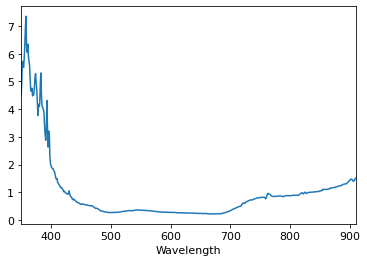

In [63]:
(flameavg/asdavg).plot(xlim=(350,910))#, ylim=(0.5,1))

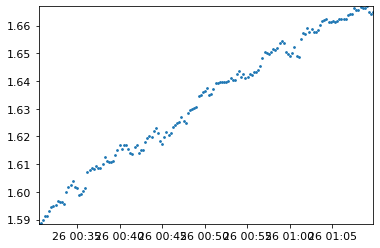

In [64]:
scatter_plot(gpta['date_saved'], gpta['Averaged_Panels'])
#plt.xlim(datetime(2020,5,4,0,15,30), datetime(2020,5,4,0,15,55))

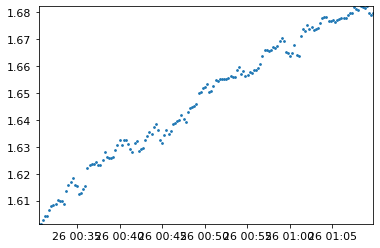

In [65]:
scatter_plot(all_panels[all_panels.Wavelength==450].date_saved, all_panels[all_panels.Wavelength==450].radiance)
#plt.xlim(datetime(2020,5,4,0,1), datetime(2020,5,4,0,20))
#plt.ylim(52,57)

### Apply weighted band responses to all reflectances

In [66]:
for i in range(910, 2501):
    all_refls.loc[i] = all_refls.loc[909]

In [67]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [68]:
ls_ground_bands = ReformatDF.reformat_df(good_grounds, ls_result_df)
s2_ground_bands = ReformatDF.reformat_df(good_grounds, s2_result_df)

# Figure 

### Plot band reflectances

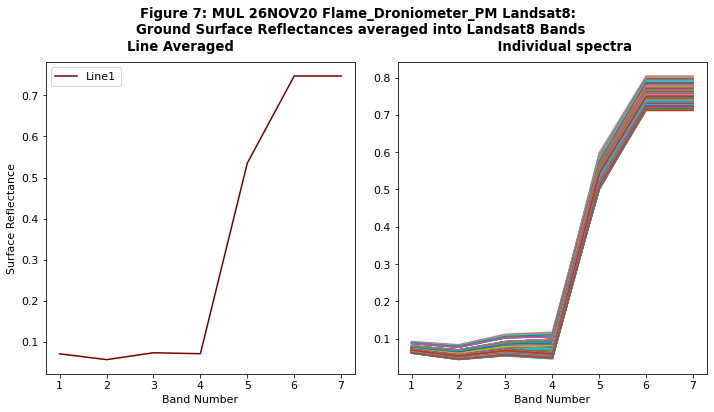

In [69]:
FIG_BandReflectances.FIG_band_reflectances(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, colpac, outdir, field_data, fignum)

fignum += 1

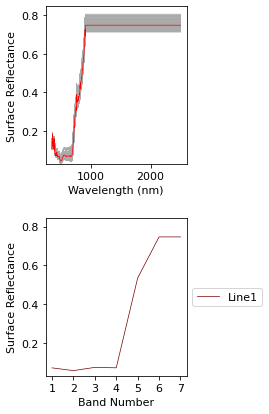

In [70]:
FIG_ReflectancesBand.FIG_reflectances_band(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, good_panels, all_refls, colpac, outdir, field_data, fignum)

fignum += 1

In [71]:
#s2_ground_bands = add_polar_points(s2_ground_bands)

In [72]:
#polar_plot(s2_ground_bands.compass_heading, s2_ground_bands.gimbal_pitch, s2_ground_bands.band3, outdir, field_data, fignum)

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

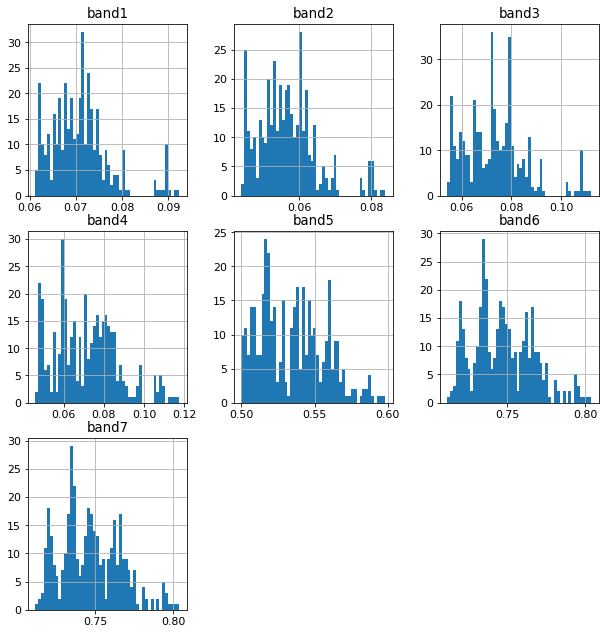

In [73]:
FIG_SpecHistogram.FIG_spec_histogram(ls_ground_bands, s2_ground_bands, outdir, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [74]:
OutlyingSpec.outlying_spec(ls_ground_bands, s2_ground_bands, field_data)

Maximum value found in: mul150811__0552__01-25-56-175.txt 
 band1    0.092445
band2    0.083933
band3    0.112199
band4    0.117595
band5    0.587566
band6    0.794432
band7    0.794432
Name: 146, dtype: float64 
Minimum value found in: mul150811__0812__01-29-14-477.txt 
 band1    0.061255
band2    0.043960
band3    0.054443
band4    0.046036
band5    0.549382
band6    0.755565
band7    0.755565
Name: 288, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [75]:
from SRC.SolarAngle import solang
ls_ground_bands['Solar_angle'] = ls_ground_bands.apply(solang, axis=1)
s2_ground_bands['Solar_angle'] = s2_ground_bands.apply(solang, axis=1)

### Determine BRDF parameters
Given the latitude an longitude of the field site, determine the BRDF parameters that will be applied.

In [76]:
brdf_data = PrintBRDF.print_brdf(merge_data, field_data)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [77]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_ground_bands, s2_ground_bands, field_data)

### Choose bands for Landsat 8 and Sentinel satellite data

In [78]:
from SRC.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

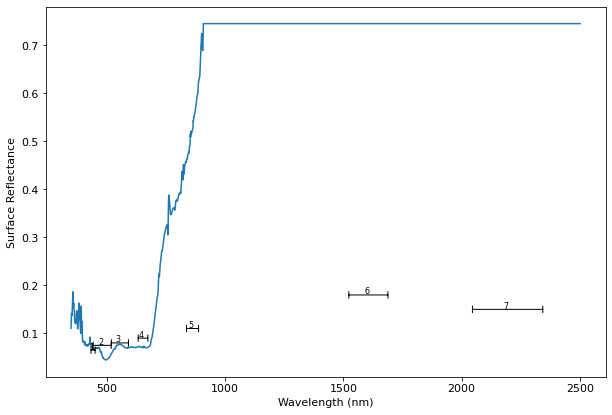

In [79]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, outdir, field_data, fignum)
fignum += 1

In [80]:
ls_ground_brdf_ASD = pd.read_pickle('PICKS/10NOV20_ls_ground_brdf.pick')
s2_ground_brdf_ASD = pd.read_pickle('PICKS/10NOV20_s2_ground_brdf.pick')

(-35.1235, -35.1222)

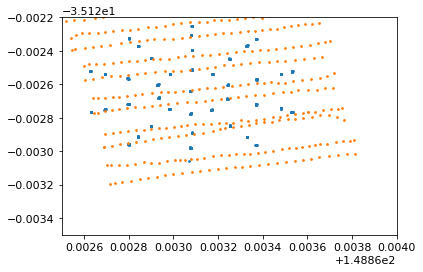

In [81]:
scatter_plot(s2_ground_brdf.Longitude, s2_ground_brdf.Latitude)
scatter_plot(s2_ground_brdf_ASD.Longitude, s2_ground_brdf_ASD.Latitude)
plt.xlim(148.8625, 148.8640)
plt.ylim(-35.1235, -35.1222)

In [82]:
ls_fudate = ls_ground_brdf_ASD.copy()
s2_fudate = s2_ground_brdf_ASD.copy()
ls_fudate.date_saved = datetime(2020,11,26)
s2_fudate.date_saved = datetime(2020,11,26)

### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.<BR>
ls8_usgs_array will contain the USGS Level 2 product of Landsat 8 data.<BR>
ls8_usgs_bigarray will be the larger version of ls8_usgs_array.<P>
    
BRDF data is sourced/applied from satellite yaml file to match field and satellite processing for Landsat 8.<BR>
ground_WSbrdf is the brdf calculated for the whole of scene (based on satellite yaml file).

In [83]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_ground_brdf, s2_ground_brdf, ls_ground_bands, s2_ground_bands, field_data, Corners, RockWalk, StartCorner)

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/pub

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/pub

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/pub

Assuming good GPS Coordinates, continuing...


# Figure 

### Plot relative locations of field and satellite data

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

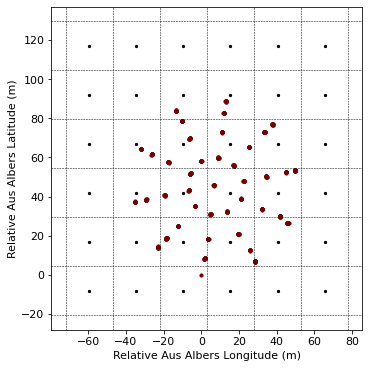

In [84]:
ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, outdir, field_data, fignum)
fignum +=1

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

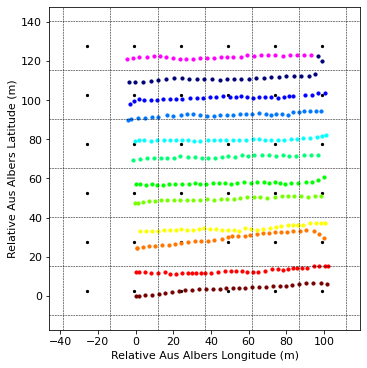

In [85]:
ls_ASD_xloc, s2_ASD_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf_ASD, s2_ground_brdf_ASD, ls_sat_array, s2_sat_array, colpac, outdir, field_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [86]:
ls_field_array, s2_field_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)
ls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)

In [87]:
ls_field_ASD_array, s2_field_ASD_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, ls_ASD_xloc, s2_ASD_xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

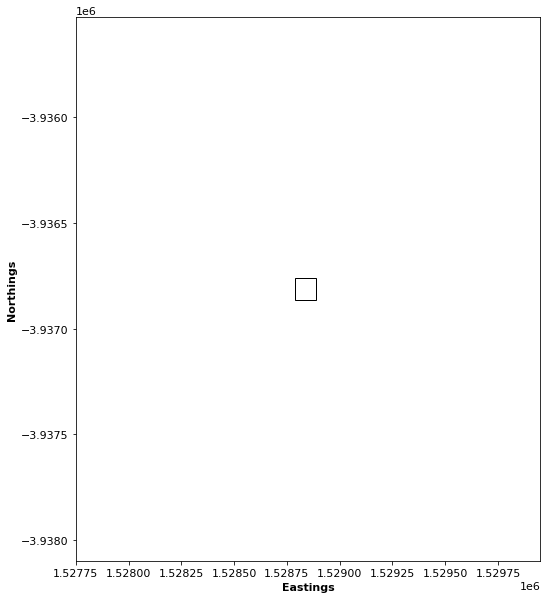

In [88]:
if field_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(ls_sat_array, ls_sat_bigarray, outdir, field_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(s2_sat_array, s2_sat_bigarray, outdir, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Satellite data

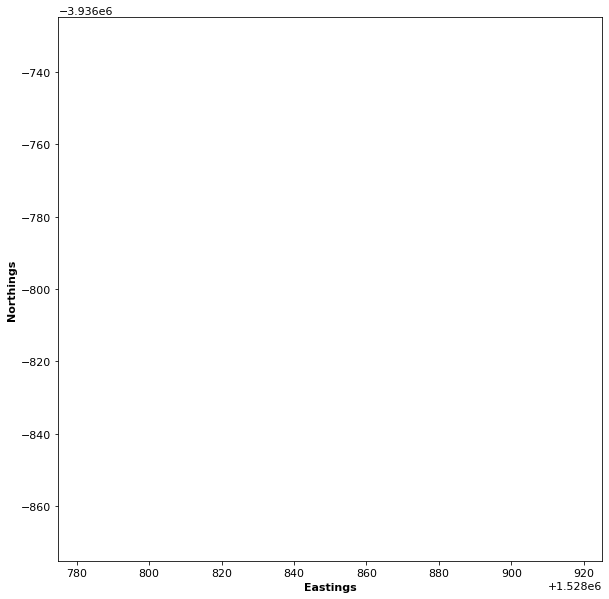

In [89]:
if field_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(ls_sat_array, outdir, field_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(s2_sat_array, outdir, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

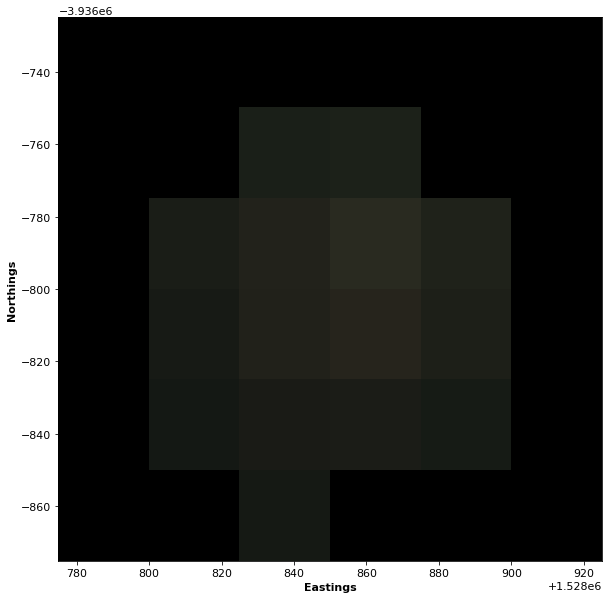

In [90]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, outdir, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_array, outdir, field_data, fignum)
fignum += 1

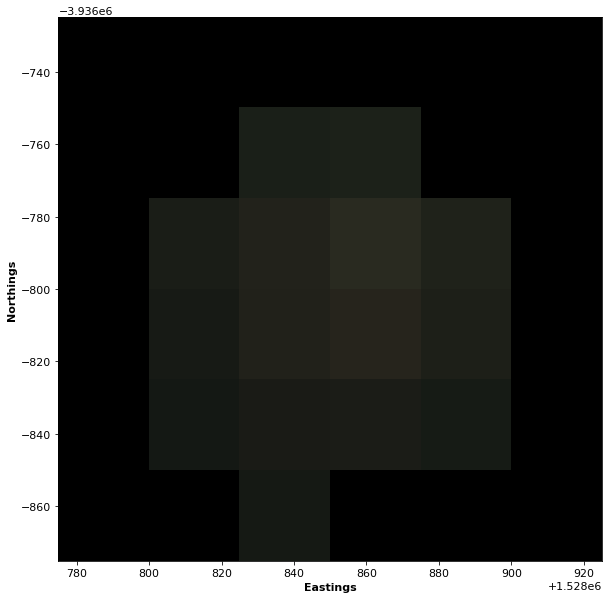

In [91]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, outdir, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_ASD_array, outdir, field_data, fignum)
fignum += 1

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min, max and mean variance. Variance is defined as the ratio of the standard
deviation divided by the mean, for each band. The mean variance should typically be less than 5%.

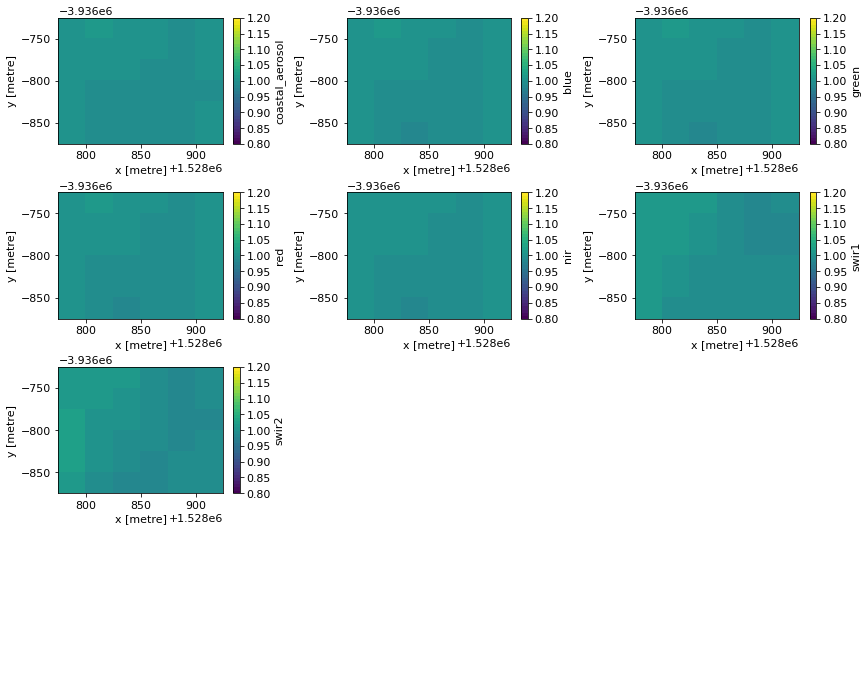

In [92]:
if field_data[3] == 'Landsat8':
    variance = FIG_SatBands.FIG_sat_bands(ls_sat_array, ls_field_WSarray, outdir, field_data, fignum)
else:
    variance = FIG_SatBands.FIG_sat_bands(s2_sat_array, s2_field_array, outdir, field_data, fignum)
fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

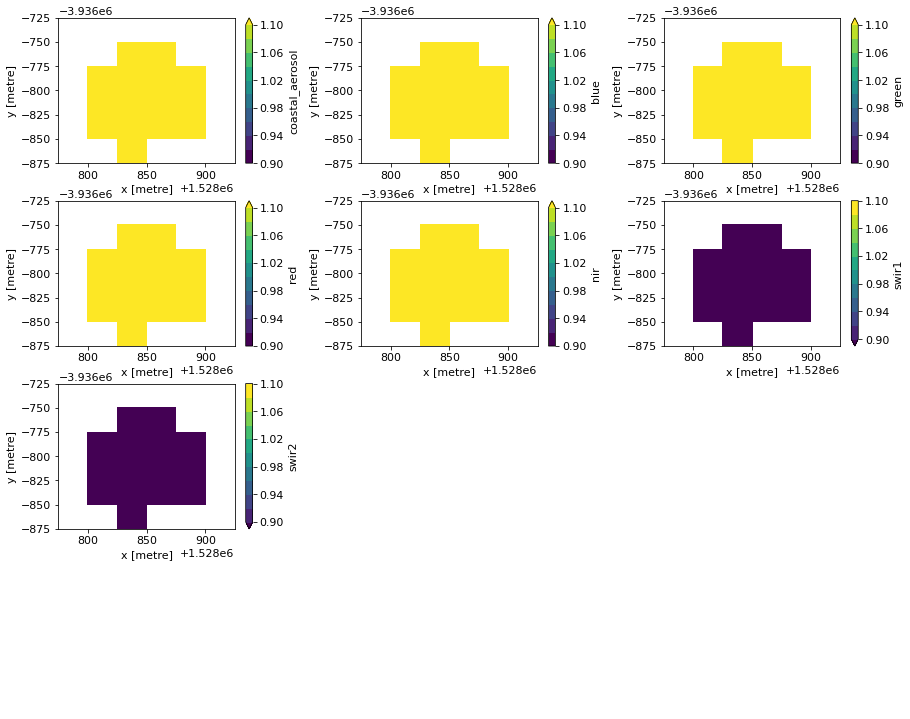

In [93]:
if field_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(ls_sat_array, ls_field_WSarray, outdir, field_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(s2_field_ASD_array, s2_field_array, outdir, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [94]:
ls_fstat_df, s2_fstat_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
ls_fstat_WSdf, dummy = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

if field_data[6] == 'USGS':
    ls_fstat_usgs_df, dummy = CreateStats.create_stats(ls8_usgs_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
else:
    ls_fstat_usgs_df = 0

In [95]:
ls_fstat_ASD_df, s2_fstat_ASD_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, field_data)

In [96]:
s2_fstat_ASD_df

,Sat_mean,Sat_SD,Field_mean,Field_SD,Sat_SD/mean (%),Field_SD/mean (%),Sat/Field
Band1,0.027548,0.000383,0.022895,0.003837,1.389082,16.759723,1.203227
Band2,0.033065,0.002301,0.031881,0.005643,6.958253,17.699352,1.037130
Band3,0.066381,0.003230,0.068503,0.009252,4.866022,13.505607,0.969031
Band4,0.048950,0.005455,0.043628,0.011571,11.144908,26.521616,1.121996
Band5,0.125061,0.005216,0.116060,0.017217,4.170904,14.834219,1.077547
Band6,0.311665,0.006382,0.322028,0.028972,2.047731,8.996767,0.967820
Band7,0.396971,0.008743,0.437265,0.042076,2.202375,9.622544,0.907850
Band8,0.443940,0.012272,0.469904,0.043464,2.764381,9.249473,0.944747
Band8a,0.456297,0.010171,0.486995,0.044242,2.229005,9.084780,0.936965
Band11,0.169320,0.006560,0.165672,0.020213,3.874257,12.200351,1.022019


## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [97]:
ls_finner_df, s2_finner_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_array, s2_field_array, ls_ground_brdf, s2_ground_brdf, ls_fstat_df, s2_fstat_df, field_data)
ls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_WSarray, s2_field_array, ls_ground_WSbrdf, s2_ground_brdf, ls_fstat_WSdf, s2_fstat_df, field_data)
ls_finner_ASD_df, s2_finner_ASD_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_ASD_array, s2_field_ASD_array, ls_ground_brdf_ASD, s2_ground_brdf_ASD, ls_fstat_ASD_df, s2_fstat_ASD_df, field_data)


# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

(100.0, 500.0)

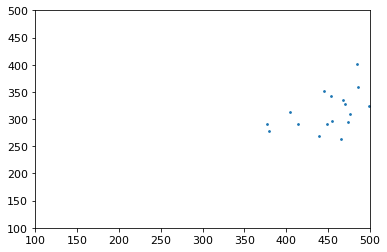

In [98]:
scatter_plot(s2_field_array.nbart_blue, s2_field_ASD_array.nbart_blue)
plt.xlim(100,500)
plt.ylim(100,500)

In [99]:
plorp = s2_field_array/s2_field_ASD_array

In [100]:
for i in plorp:
    print(round(float(plorp[i].mean().values), 3), round(float(plorp[i].std().values), 3))

2.694 0.265
1.528 0.225
0.973 0.136
1.394 0.345
1.011 0.138
0.787 0.061
0.778 0.066
0.923 0.069
1.031 0.074
3.932 0.34
8.47 0.734


In [101]:
both = pd.merge(s2_fstat_df, s2_fstat_ASD_df, on=s2_fstat_df.index)

In [102]:
both.set_index('key_0', inplace=True)

In [103]:
both

,Sat_mean_x,Sat_SD_x,Field_mean_x,Field_SD_x,Sat_SD/mean (%)_x,Field_SD/mean (%)_x,Sat/Field_x,Sat_mean_y,Sat_SD_y,Field_mean_y,Field_SD_y,Sat_SD/mean (%)_y,Field_SD/mean (%)_y,Sat/Field_y
key_0,,,,,,,,,,,,,,
Band1,0.027548,0.000383,0.061649,0.005375,1.389082,8.718698,0.446857,0.027548,0.000383,0.022895,0.003837,1.389082,16.759723,1.203227
Band2,0.033065,0.002301,0.047880,0.007409,6.958253,15.474156,0.690591,0.033065,0.002301,0.031881,0.005643,6.958253,17.699352,1.037130
Band3,0.066381,0.003230,0.064360,0.010425,4.866022,16.198589,1.031402,0.066381,0.003230,0.068503,0.009252,4.866022,13.505607,0.969031
Band4,0.048950,0.005455,0.059720,0.013349,11.144908,22.351943,0.819656,0.048950,0.005455,0.043628,0.011571,11.144908,26.521616,1.121996
Band5,0.125061,0.005216,0.114070,0.015810,4.170904,13.859811,1.096346,0.125061,0.005216,0.116060,0.017217,4.170904,14.834219,1.077547
Band6,0.311665,0.006382,0.247681,0.016611,2.047731,6.706544,1.258331,0.311665,0.006382,0.322028,0.028972,2.047731,8.996767,0.967820
Band7,0.396971,0.008743,0.333650,0.019136,2.202375,5.735408,1.189785,0.396971,0.008743,0.437265,0.042076,2.202375,9.622544,0.907850
Band8,0.443940,0.012272,0.427549,0.019614,2.764381,4.587461,1.038337,0.443940,0.012272,0.469904,0.043464,2.764381,9.249473,0.944747
Band8a,0.456297,0.010171,0.496140,0.020772,2.229005,4.186653,0.919695,0.456297,0.010171,0.486995,0.044242,2.229005,9.084780,0.936965


In [104]:
both['fratio'] = both['Field_mean_x']/both['Field_mean_y']

In [105]:
both

,Sat_mean_x,Sat_SD_x,Field_mean_x,Field_SD_x,Sat_SD/mean (%)_x,Field_SD/mean (%)_x,Sat/Field_x,Sat_mean_y,Sat_SD_y,Field_mean_y,Field_SD_y,Sat_SD/mean (%)_y,Field_SD/mean (%)_y,Sat/Field_y,fratio
key_0,,,,,,,,,,,,,,,
Band1,0.027548,0.000383,0.061649,0.005375,1.389082,8.718698,0.446857,0.027548,0.000383,0.022895,0.003837,1.389082,16.759723,1.203227,2.692645
Band2,0.033065,0.002301,0.047880,0.007409,6.958253,15.474156,0.690591,0.033065,0.002301,0.031881,0.005643,6.958253,17.699352,1.037130,1.501801
Band3,0.066381,0.003230,0.064360,0.010425,4.866022,16.198589,1.031402,0.066381,0.003230,0.068503,0.009252,4.866022,13.505607,0.969031,0.939528
Band4,0.048950,0.005455,0.059720,0.013349,11.144908,22.351943,0.819656,0.048950,0.005455,0.043628,0.011571,11.144908,26.521616,1.121996,1.368861
Band5,0.125061,0.005216,0.114070,0.015810,4.170904,13.859811,1.096346,0.125061,0.005216,0.116060,0.017217,4.170904,14.834219,1.077547,0.982853
Band6,0.311665,0.006382,0.247681,0.016611,2.047731,6.706544,1.258331,0.311665,0.006382,0.322028,0.028972,2.047731,8.996767,0.967820,0.769130
Band7,0.396971,0.008743,0.333650,0.019136,2.202375,5.735408,1.189785,0.396971,0.008743,0.437265,0.042076,2.202375,9.622544,0.907850,0.763037
Band8,0.443940,0.012272,0.427549,0.019614,2.764381,4.587461,1.038337,0.443940,0.012272,0.469904,0.043464,2.764381,9.249473,0.944747,0.909865
Band8a,0.456297,0.010171,0.496140,0.020772,2.229005,4.186653,0.919695,0.456297,0.010171,0.486995,0.044242,2.229005,9.084780,0.936965,1.018778


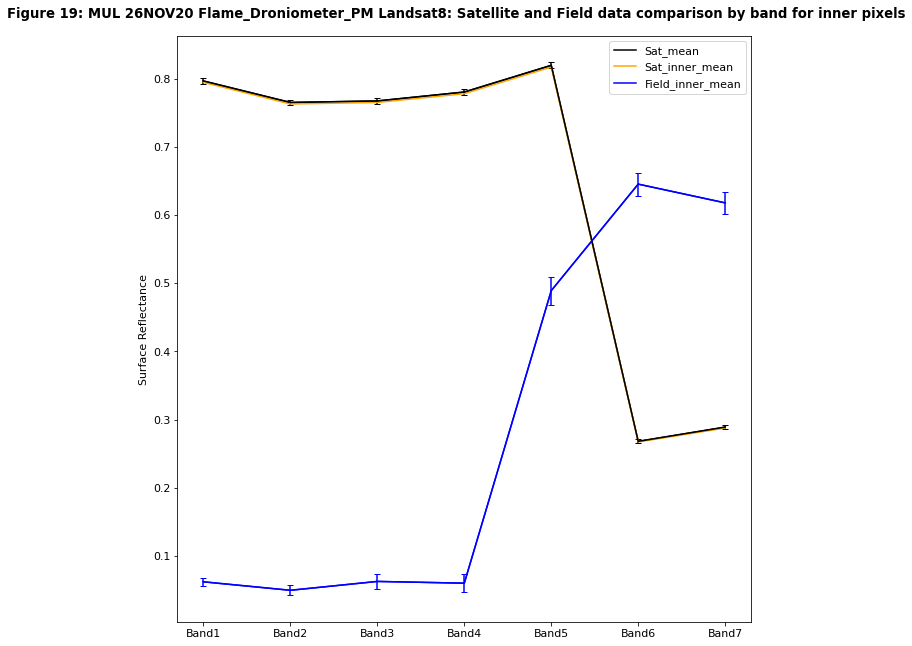

In [106]:
if field_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, outdir, field_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(s2_field_array, s2_fstat_df, s2_finner_df, outdir, field_data, fignum)
fignum += 1

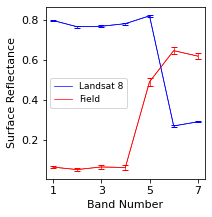

In [107]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, outdir, field_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, outdir, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

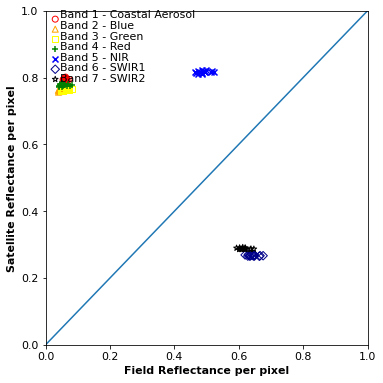

In [108]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, outdir, field_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(s2_sat_array, s2_field_array, plot_scale, outdir, field_data, fignum)
fignum += 1

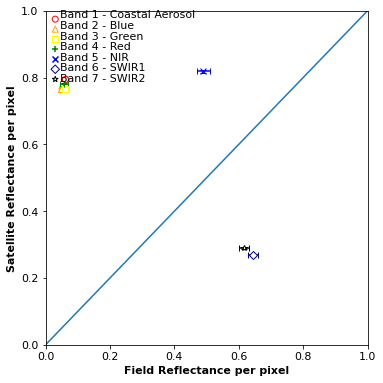

In [109]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, ls_fstat_WSdf, outdir, field_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(s2_sat_array, s2_field_array, plot_scale, s2_fstat_df, outdir, field_data, fignum)
fignum += 1

## Print out summary data sheet

In [110]:
if field_data[3] == 'Landsat8':
    PrintSheet.print_sheet(ls_ground_WSbrdf, ls_sat_array, ls_fstat_WSdf, indir, outdir, field_data, Corners, RockWalk, StartCorner, variance, ls_query, ls_dc)
else:
    PrintSheet.print_sheet(s2_ground_brdf, s2_sat_array, s2_fstat_df, indir, outdir, field_data, Corners, RockWalk, StartCorner, variance, s2_query, s2_dc)

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/pub

In [113]:
OutputCSVs.output_csvs(ls_fstat_df, s2_fstat_df, ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)

Difference in time between field site measurement and LS8 data is -4 days +22:34:34.515000


## How long did this notebook take to run?

In [112]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

NameError: name 'start_time' is not defined

In [ ]:
in_panel_dir = '../MULLION/10NOV20/asd_panels/'
plop = LoadASDData.load_from_dir(in_panel_dir, '.asd.rad.txt', 1, Corners)

In [ ]:
plop.set_index('Wavelength', inplace=True)

In [ ]:
plop[plop.Wavelength==550].plot('date_saved', 'radiance')

In [ ]:
plop = plop.rename(columns={'Spec_number': 'SpecNum'})

In [ ]:
plop2 = MakeSpecDF.make_spec_df(plop)


In [ ]:
medplop = plop2.median(axis=1)

In [ ]:
plop3 = plop2.div(medplop, axis=0)

In [ ]:
plop3.plot(ylim=(0.99, 1.01), legend=False)

In [ ]:
plop3[np.logical_and(plop3.index>500, plop3.index<600)].mean(axis=0).plot()

In [ ]:
plt = plop[plop.Wavelength==550].plot('date_saved', 'radiance', legend=False)
fig = plt.get_figure()
fig.savefig('asd_panel.png')

In [ ]:
plt = all_grounds[all_grounds.Wavelength==550].plot('date_saved', 'radiance', legend=False)
fig = plt.get_figure()
fig.savefig('flame_panel.png')

In [ ]:
scatter_plot(all_grounds[all_grounds.Wavelength==550].date_saved, all_grounds[all_grounds.Wavelength==550].radiance)

In [ ]:
plop.Longitude = plop.Longitude.fillna(148.862692)
plop.Latitude = plop.Latitude.fillna(-35.123277)
plop, all_grounds = SolarAngle.solar_angle(plop, all_grounds, field_data)
plop = PanelBRF.Panel_BRF(plop, field_data)

In [ ]:
all_panel_spec = MakeSpecDF.make_spec_df(plop)

In [ ]:
gpta, adta = CreateTimeRelativeDF.create_time_relative_dfs(plop, all_grounds)

In [ ]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, outdir, field_data, fignum)
fignum += 1

In [ ]:
all_panel_mean = all_panel_spec.mean(axis=1)

gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(all_panel_mean, all_panel_spec, gpta, field_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpta, outdir, field_data, fignum)

fignum += 1

In [ ]:
s2_ground_brdf_ASD.date_saved.min()